#### Grid search with cross-validation

In the previous unit, we used cross-validation to compute a more accurate estimation of the generalization performance. In practice, we usually combine cross-validation with grid search to tune hyperparameters without using the final test set. Let’s see how.

#### Grid search with cross-validation
In this unit, we will tune a logistic regression estimator for the iris data.



In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create pipeline
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(multi_class="ovr", solver="liblinear")),
    ]
)

We saw in the last units that the LogisticRegression object has a C regularization parameter. We could split our data into train/test sets and use grid search to find the best value. However, this isn’t optimal as we are using the test set to “tune” C - ideally, we should leave the test data out of any training loop and only use it at the end to have a final test estimation on new/unseen data points.

One solution is to further split the train set into a smaller train and validation ones. The idea is to use the small train set to fit the different estimators with varying C values, use the validation one to compare them and finally, pick the best performing value C*, refit the tuned estimator to the entire train set and compute a final test error estimation with the test set.

This simple train/validation/test sets strategy works well when we have a lot of data and we will use it to tune our deep learning models or other computationally costly models at the end of the course. However, it’s possible to do better: instead of splitting the data into a single train/validation pair to estimate the generalization error of the different hyperparameter combinations, we can use cross-validation which has two advantages

* It returns better estimates since we perform evaluation several times
* All the training data is being used i.e. validation data is reused as training data across different folds

It’s important to note that cross-validation is also more computationally costly, we perform the fit/eval loop several times. For this reason, we typically keep the simple train/valid/test set strategy for computationally costly models when we have enough data.

#### Scikit-learn GridSearchCV
Scikit-learn provides a GridSearchCV object to perform grid search with cross-validation. The object takes the estimator, a grid of parameters and the cross-validator object.

In [2]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Create cross-validation object
grid = {"logreg__C": np.logspace(-4, 4, num=10)}
grid_cv = GridSearchCV(pipe, grid, cv=5, return_train_score=True)

In this case, we pass ten C values on a log scale between 10^(-4) and 10^4 and set the cv strategy to 5-fold cross-validation (stratified by default for classification tasks).



Running a cross-validation on top of a grid search can computationally be very demanding on your system. Under certain conditions, this might lead to a “never ending” model fit. To better understand what is happening, and to see how quickly the model fit progresses, GridSearchCV (as many other Python functions) offers the verbose=1 parameter. Setting verbose to 1, will tell you how many grid points the model needs to compute and how long it takes for each.

Additionally, a potential strategy to speed up GridSearchCV is to use the n_jobs parameter. n_jobs allows your computer to run the grid search in parallel, if possible. Using n_jobs=-1 will allow your computer to run as many parallel jobs as possible (which depends on your CPU). Keep in mind, on some machines n_jobs=-1 might also lead to “never ending” computation cycles. In this case, we recommend to set n_jobs to a specific value, such as 2, 4 or 8.

We can now use grid_cv as a standard Scikit-learn estimator. Let’s fit it to the iris data



In [3]:
from sklearn import datasets

# Load dataset
iris = datasets.load_iris()

# Create X/y arrays
X = iris["data"]
y = iris["target"]

# Fit estimator
grid_cv.fit(X, y)

# Get the results with "cv_results_"
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_logreg__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

The cross-validation results are stored in a cv_results_ dictionary attribute. In particular, the mean_train_score and mean_test_score entries contain the mean scores on the train and validation sets for each combination of hyperparameters

In [4]:
# Mean test scores
grid_cv.cv_results_["mean_test_score"]

array([0.8       , 0.81333333, 0.82      , 0.82666667, 0.86      ,
       0.92      , 0.95333333, 0.96      , 0.96      , 0.96      ])

In this case, the largest C values (small regularization strengths) have the best test accuracy.

Let’s use a Pandas DataFrame to better visualize the cv_results_



In [5]:
import pandas as pd

# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "param_logreg__C",
]
cv_results[cols].sort_values("mean_test_score", ascending=False)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_logreg__C
7,0.960000,0.024944,0.966667,0.011785,166.810054
8,0.960000,0.024944,0.975000,0.010541,1291.549665
9,0.960000,0.024944,0.976667,0.013333,10000.0
6,0.953333,0.033993,0.963333,0.006667,21.544347
5,0.920000,0.061824,0.948333,0.011055,2.782559
4,0.860000,0.061101,0.881667,0.009718,0.359381
3,0.826667,0.057349,0.835000,0.015275,0.046416
2,0.820000,0.080554,0.821667,0.020138,0.005995
1,0.813333,0.077746,0.808333,0.018257,0.000774
0,0.800000,0.066667,0.803333,0.017159,0.0001


We will focus on a subset of the columns. Note that hyperparameter values are prefixed by param_ and then the parameter name. In our case, param_logreg__C i.e. the C parameter of the logreg step from our pipeline

The top mean test scores are around 96% with a standard deviation between 2-3%. Let’s plot the training and validation curves to better see the effect of C.

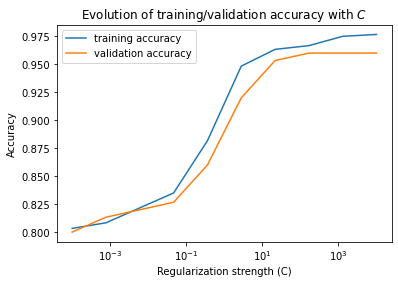

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot training/validation accuracy curves
plt.semilogx(cv_results["param_logreg__C"], cv_results["mean_train_score"], label='training accuracy')
plt.semilogx(cv_results["param_logreg__C"], cv_results["mean_test_score"],  label='validation accuracy')
plt.xlabel('Regularization strength (C)')
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with $C$")
plt.legend()
plt.show()

Note the log scale on the x-axis.

It seems that regularization isn’t helpful in our case. Our logistic regression model isn’t overfitting and adding regularization hurts performance i.e. underfitting.

#### Making predictions
The GridSearchCV object has a refit parameter which is set to True by default - it automatically refits the best estimator to the entire train data and saves it in a best_estimator_ attribute.

We can use it as a standard Scikit-learn estimator ex. to make new predictions



In [7]:
# Compute predictions with the "best_estimator_" attribute
grid_cv.best_estimator_.predict(X)

# Or with the grid search object directly
grid_cv.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Note that we don’t need to write grid_cv.best_estimator_ - grid_cv automatically uses the best estimator when calling predict() or other functions related to it such as score().

#### LogisticRegressionCV object
GridSearchCV can tune any estimator using grid search with cross-validation. However, note that Scikit-learn also implements dedicated objects for some models. For instance, the LogisticRegressionCV one let’s us define a list of C values to tune with cross-validated grid search

In [8]:
from sklearn.linear_model import LogisticRegressionCV

# Create estimator
logreg_cv = LogisticRegressionCV(
    Cs=[0.1, 1, 10], cv=5, multi_class="ovr", solver="liblinear"
)

In this code, we create a logistic regression estimator that tunes its C value using a 5-fold cross-validation.

Estimators with built-in cross-validation are usually more efficient than the generic GridSearchCV object. However, they don’t integrate with pipelines. More specifically, we cannot pass a set of preprocessing steps to apply to each training fold. Instead, we have to preprocess the data globally before the estimator



In [9]:
from sklearn.preprocessing import scale

# Fit the estimator
logreg_cv.fit(scale(X), y)

LogisticRegressionCV(Cs=[0.1, 1, 10], cv=5, multi_class='ovr',
                     solver='liblinear')

In this case, we standardize the entire input data which implies that we used data from the validation folds which isn’t optimal i.e. compute standardization mean/std on all data.

LogisticRegressionCV stores the cross-validated results in a scores_ attribute. Due to the One-versus-Rest (OvR) strategy, it has one entry per class. For instance, let’s print the cross-validated results from our “class 1” vs “classes 2, 3” classifier



In [10]:
# Scores for class 1 (Setosa)
logreg_cv.scores_[0]


array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

The result is a table with 5 rows that correspond to each fold and 3 columns for the C values. In this case, we get an accuracy of 100% for each fold and regularization strength because Setosa flowers are very different from the two other types and it’s easy to classify them.

Let’s take a look at the results for the Versicolor category (class 2)



In [11]:
# Scores for class 2 (Versicolor)
logreg_cv.scores_[1]

array([[0.66666667, 0.66666667, 0.63333333],
       [0.7       , 0.7       , 0.7       ],
       [0.66666667, 0.76666667, 0.73333333],
       [0.8       , 0.76666667, 0.76666667],
       [0.73333333, 0.76666667, 0.76666667]])

This time, the second column has slightly better results than the two other ones. We can see it by printing the mean scores

In [12]:
# Mean score per C value across folds
logreg_cv.scores_[1].mean(axis=0)

array([0.71333333, 0.73333333, 0.72      ])

Hence, the LogisticRegressionCV object will use the second C value C=1 for the virginica class. We can verify this by printing the C values for the three classes

In [13]:
print(logreg_cv.C_)

[ 0.1  1.  10. ]


As expected, the second class, virginica flowers, has C=1

#### Summary
In this unit, we saw two different ways to combine cross-validation and grid search

GridSearchCV - A generic object to tune the hyperparameters of any estimator
LogisticRegressionCV - A logistic regression with built-in cross-validation for C
The estimators with built-in cross-validation are usually more efficient than the generic GridSearchCV object, but cannot integrate preprocessing steps.

In the next exercise, you will work on the multiclass heart disease diagnosis task. This time, you will tune the hyperparameters of a k-NN and a logistic regression estimator using a cross-validated grid search.